In [28]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
from plot_utils import *
env_exp_dir = Path.cwd()/env_name/'distributed'

In [29]:
actors_dict = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda: defaultdict(list)))) #experiment_dict: actors dict: learning_step_dict: stats_dict: list
for exp in experiment_list:
    current_exp_dir = env_exp_dir/exp
    runs = (runs_dir(current_exp_dir))
    runs.sort()
    for run in runs:
        current_run_dir = current_exp_dir/run
        actors_csvs = actors_dir(current_run_dir)
        actors_csvs.sort()
        for actor_csv in actors_csvs:
            df =pd.read_csv(current_run_dir/actor_csv, index_col = 0)
            for index, row in df.iterrows():
                actors_dict[exp][actor_csv][index]['mean'].append(row['return_mean'])
                actors_dict[exp][actor_csv][index]['std'].append(row['return_std'])
                actors_dict[exp][actor_csv][index]['num_samples'].append(row['num_samples'])
                actors_dict[exp][actor_csv][index]['num_success'].append(row['num_success'])

In [30]:
combined_actor = defaultdict(lambda: defaultdict(lambda: defaultdict(list))) #experiments_dict: actors dict: learning_step_dict: stats_dict: list
for exp in experiment_list:
    for actor, actor_values in actors_dict[exp].items():
        for learning_step, learning_step_values in actor_values.items():
            means, stds, num_samples, num_success = learning_step_values.values()
            combined_actor[exp][learning_step]['mean']+=means
            combined_actor[exp][learning_step]['std']+=stds
            combined_actor[exp][learning_step]['num_samples']+=num_samples
            combined_actor[exp][learning_step]['num_success']+=num_success

In [23]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
# labels = ['rr=0.140\nactors=1','rr=0.054\nactors=3','rr=0.032\nactors=5','rr=0.023\nactors=7','rr=0.017\nactors=9']
0.140
0.054
0.032
0.023
0.017

0.017

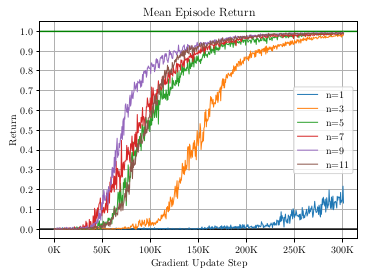

In [31]:
from collections import deque

x_ticks = np.arange(0, 2000001, step = 50000)
y_ticks = np.arange(-0.2, 1.05, step = 0.1)
y_ticks_per = np.arange(0, 101, step = 10)


# fig = create_std_fig('Success Rate over Gradient Updates', 'Iteration', '% Success Rate', x_ticks, y_ticks_per)
# plt.xticks(x_ticks, ['{:.0f}'.format(x) + 'K' for x in x_ticks/1000])
# axes = plt.gca()
# axes.set_ylim(bottom=-10, top = 110)
fig = create_std_fig('Mean Episode Return', 'Gradient Update Step', 'Return', x_ticks, y_ticks)
plt.xticks(x_ticks, ['{:.0f}'.format(x) + 'K' for x in x_ticks/1000])

smooth_len = 1
plt.axhline(y=0, color='k', linestyle='-')
plt.axhline(y=1, color='g', linestyle='-')

for exp, lbl in zip(experiment_list, labels):
    mean_returns_deq = deque(maxlen = smooth_len)
    std_deq = deque(maxlen = smooth_len)
    num_samples_deq = deque(maxlen=smooth_len)
    success_rates_deq = deque(maxlen = smooth_len)
    learning_steps = []
    mean_returns = []
    devs = []
    success_rates = []
    #print(actor)
    for learning_step, learning_step_values in combined_actor[exp].items():
        if learning_step >= int(2000.5e3):
            break
        means, stds, num_samples, num_success = learning_step_values.values()
        
        mean_returns_deq.append(means)
        std_deq.append(stds)
        num_samples_deq.append(num_samples)
        success_rates_deq.append(num_success)
        if len(mean_returns_deq) >= mean_returns_deq.maxlen:
            mean, std = deviance(flatten_deque(mean_returns_deq), flatten_deque(std_deq), flatten_deque(num_samples_deq))
            learning_steps.append(learning_step)
            mean_returns.append(mean)
            devs.append(std)
            success_rates.append(100*(np.sum(flatten_deque(success_rates_deq))/np.sum(flatten_deque(num_samples_deq))))            
#             mean, std = deviance(np.array(means), np.array(stds), np.array(num_samples))
#             learning_steps.append(learning_step)
#             mean_returns.append(mean)
#             devs.append(std)
#             success_rates.append(100*(np.sum(num_success)/np.sum(num_samples)))


    mean_returns = [mean for ls,mean in sorted(zip(learning_steps,mean_returns))]
    learning_steps.sort()
    #print(devs)
    plt.figure('Mean Episode Return')
    plt.plot(learning_steps, mean_returns, label = lbl, linewidth = 1)
#     plt.fill_between(learning_steps,y1= np.array(mean_returns)- np.array(devs), y2 =np.array(mean_returns)+np.array(devs),alpha=0.2)
#     plt.figure('Success Rate over Gradient Updates')    
#     plt.plot(learning_steps, success_rates, label = exp, linewidth = 1.5)
# plt.axvline(x=50000, color = 'r', linestyle='--', linewidth = 1)
# plt.axvline(x=100000, color = 'r', linestyle='--', linewidth = 1)
# plt.legend(loc = 'lower right')
# plt.savefig('successrate_steps.png')

plt.figure('Mean Episode Return')
# plt.axvline(x=50000, color = 'r', linestyle='--', linewidth = 1)
# plt.axvline(x=100000, color = 'r', linestyle='--', linewidth = 1)
plt.legend()

plt.savefig("return_steps.pgf")

No handles with labels found to put in legend.


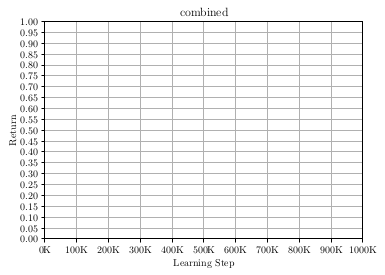

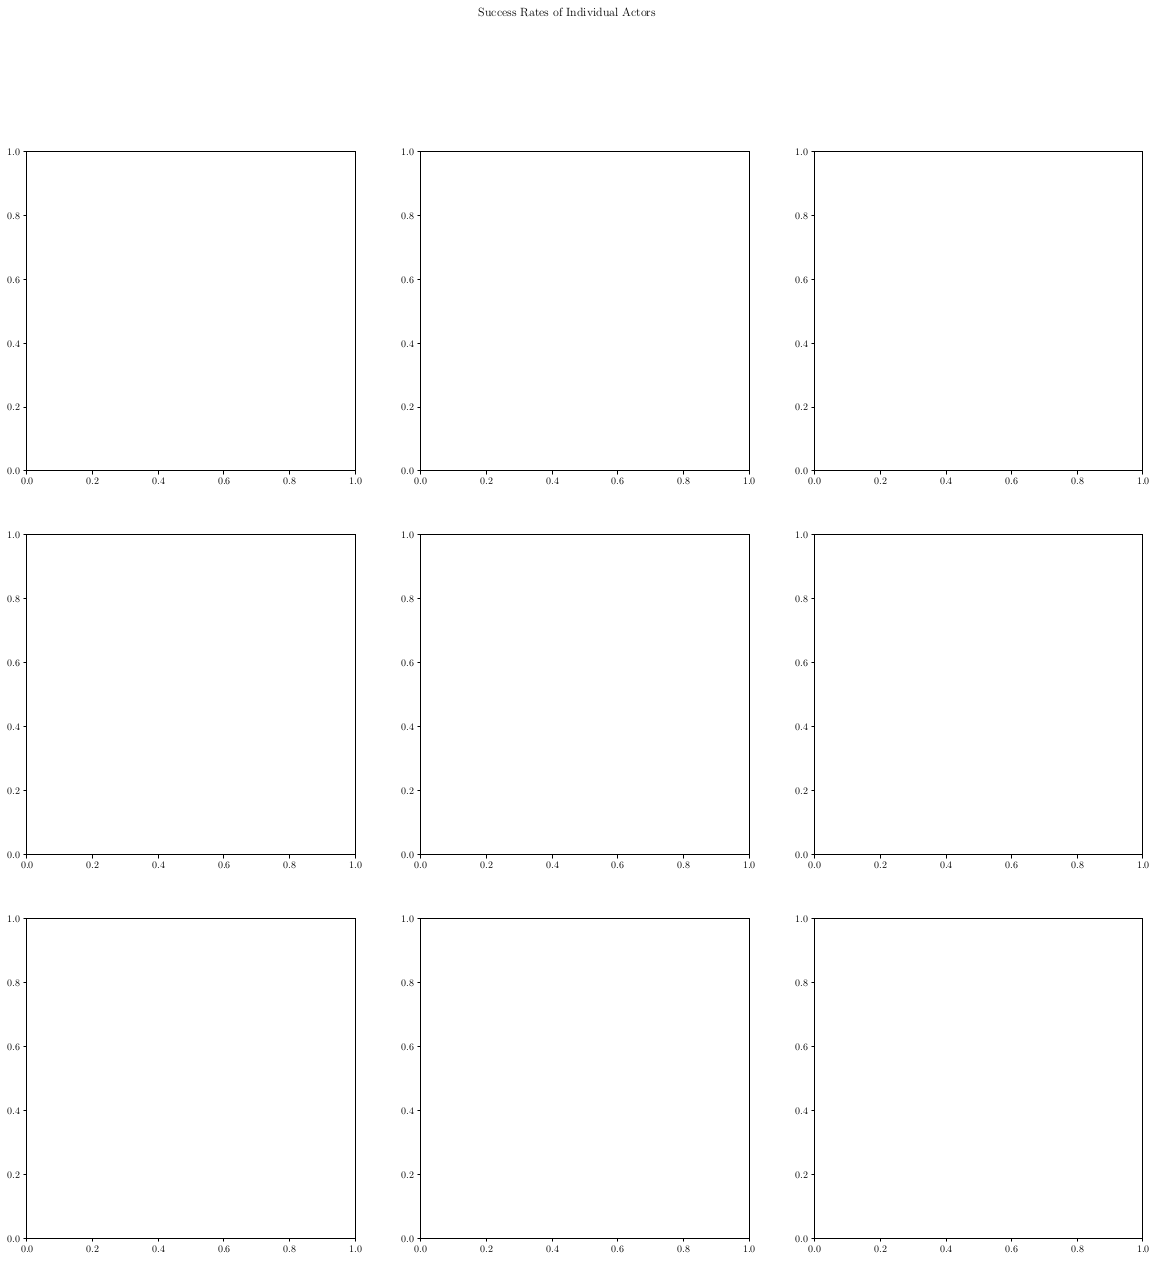

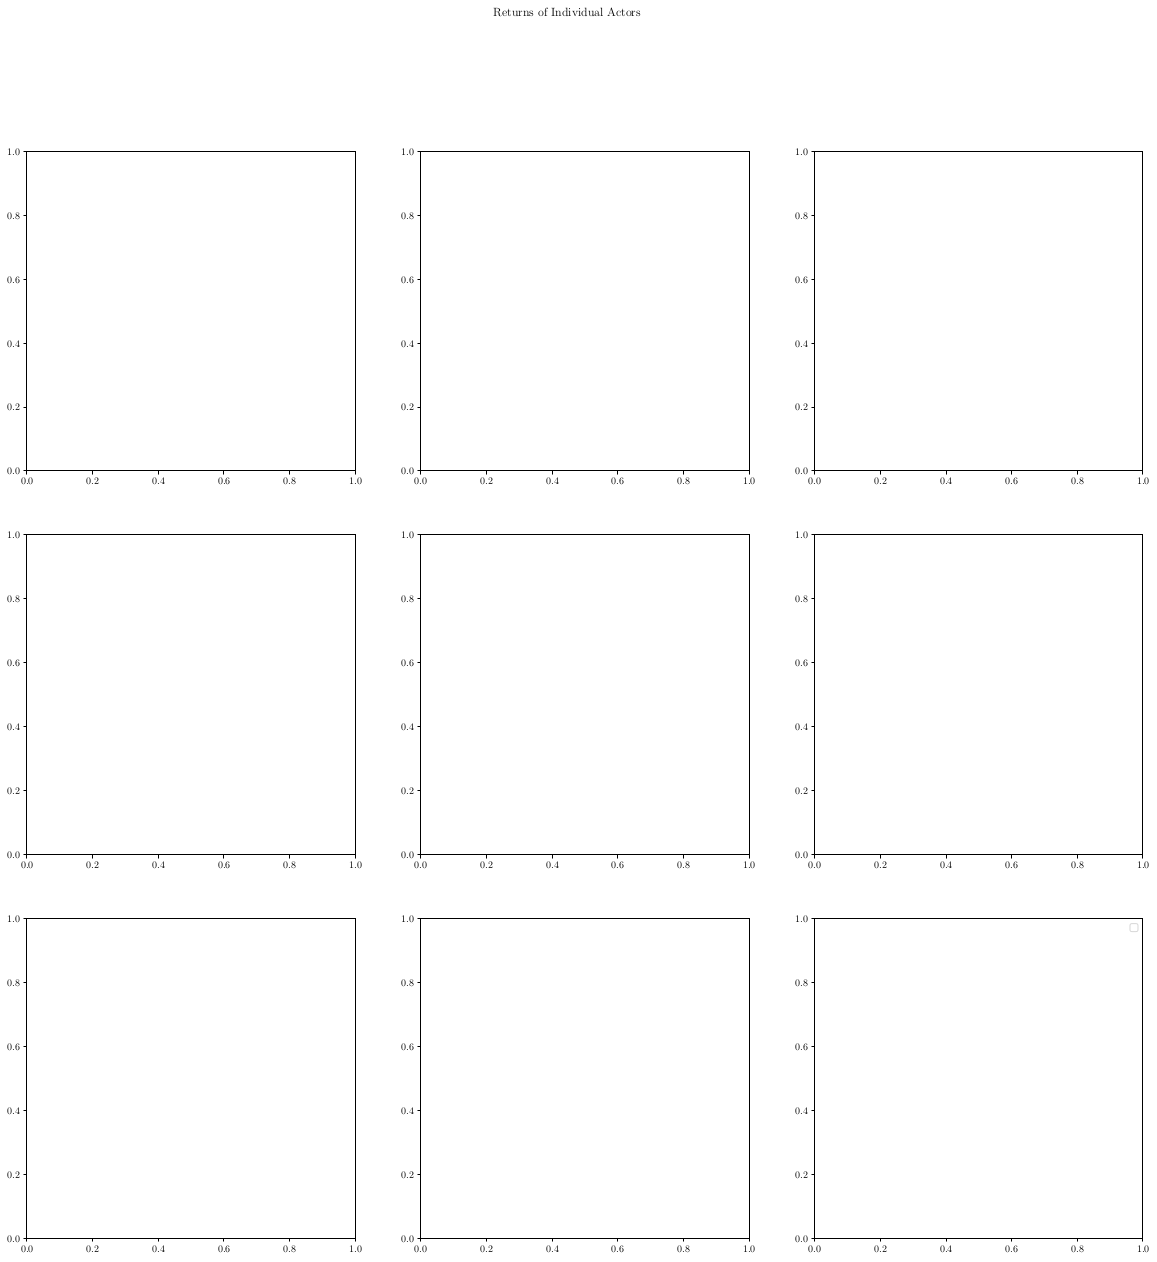

In [24]:
x_ticks = np.arange(0, 1000001, step = 100000)
y_ticks = np.arange(0, 1.05, step = 0.05)

y_ticks_per = np.arange(0, 100, step = 10)

fig = create_std_fig('combined', 'Learning Step', 'Return', x_ticks, y_ticks)
plt.xticks(x_ticks, ['{:.0f}'.format(x) + 'K' for x in x_ticks/1000])

fig_suc, axs_suc = plt.subplots(3,3, figsize=(20,20))
fig_suc.suptitle('Success Rates of Individual Actors', fontsize = 12)

fig_ret, axs_ret = plt.subplots(3,3, figsize=(20,20))
fig_ret.suptitle('Returns of Individual Actors', fontsize =12)


row = -1

exp_to_plot = '3actors'
for index,( actor, actor_values) in enumerate(actors_dict[exp_to_plot].items()):
    col = index % 3
    if index%3 ==0:
        row +=1
    xs = []
    ys = []
    devs = []
    success_rates = []
    #print(actor)
    for learning_step, learning_step_values in actor_values.items():
#       print(learning_steps)
        means, stds, num_samples, num_success = learning_step_values.values()
        success_rates.append(100*(np.sum(num_success)/np.sum(num_samples)))
        mean, std = deviance(np.array(means), np.array(stds), np.array(num_samples))
        xs.append(learning_step)
        ys.append(mean)
        devs.append(std)
    
    ys = [mean for _,mean in sorted(zip(xs,ys))]
    devs = [mean for _,mean in sorted(zip(xs,devs))]
    success_rates = [mean for _,mean in sorted(zip(xs,success_rates))]
    xs.sort()
  

    ax = axs_ret[row, col]
    ax.plot(xs, ys)
    ax.fill_between(xs,y1= np.array(ys)-np.array(devs), y2 =np.array(ys)+np.array(devs), alpha=0.1)
    ax.grid()
    ax.set_xlabel('Learning Step')
    ax.set_ylabel('Return')
    ax.set_title(actor)
    
    ax = axs_suc[row, col]
    ax.set_ylim(0, 100)
    ax.plot(xs, success_rates)
    ax.grid()
    ax.set_ylabel('% Success Rate')
    ax.set_xlabel('Learning Step')
    ax.set_title(actor)
    
    plt.figure('combined')    
    plt.plot(xs, ys, label=actor)
    #plt.fill_between(xs,y1= np.array(ys)-np.array(devs), y2 =np.array(ys)+np.array(devs), alpha=0.1)  

plt.legend()

plt.savefig('return_actors_combined.png')
# plt.figure('combined.') 
# fig_ret.savefig('return_individual_actors.png')
# fig_suc.savefig('successrate_individual_actors')


In [25]:
#time
actors_dict_time = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda: defaultdict(list)))) #experiment_dict: actors dict: minutes: stats_dict: list
for exp in experiment_list:
    current_exp_dir = env_exp_dir/exp
    runs = (runs_dir(current_exp_dir))
    runs.sort()
    for run in runs:
        current_run_dir = current_exp_dir/run
        actors_csvs = actors_dir(current_run_dir)
        actors_csvs.sort()
        
        for actor_csv in actors_csvs:
            df =pd.read_csv(current_run_dir/actor_csv, index_col = 0)
            for index, row in df.iterrows():
                minute = int(row['seconds']/60)
                actors_dict_time[exp][actor_csv][minute]['mean'].append(row['return_mean'])
                actors_dict_time[exp][actor_csv][minute]['std'].append(row['return_std'])
                actors_dict_time[exp][actor_csv][minute]['num_samples'].append(row['num_samples'])
                actors_dict_time[exp][actor_csv][minute]['num_success'].append(row['num_success'])
                

In [26]:
combined_actor_time = defaultdict(lambda: defaultdict(lambda: defaultdict(list))) #experiments_dict: actors dict: learning_step_dict: stats_dict: list
for exp in experiment_list:
    for actor, actor_values in actors_dict_time[exp].items():
        for minute, minute_values in actor_values.items():
            means, stds, num_samples, num_success = minute_values.values()
            combined_actor_time[exp][minute]['mean']+=means
            combined_actor_time[exp][minute]['std']+=stds
            combined_actor_time[exp][minute]['num_samples']+=num_samples
            combined_actor_time[exp][minute]['num_success']+=num_success

/home/jmlouw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


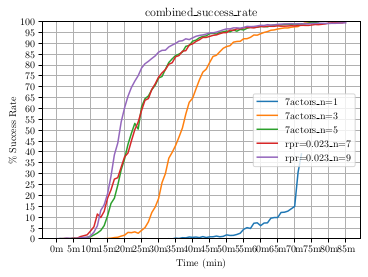

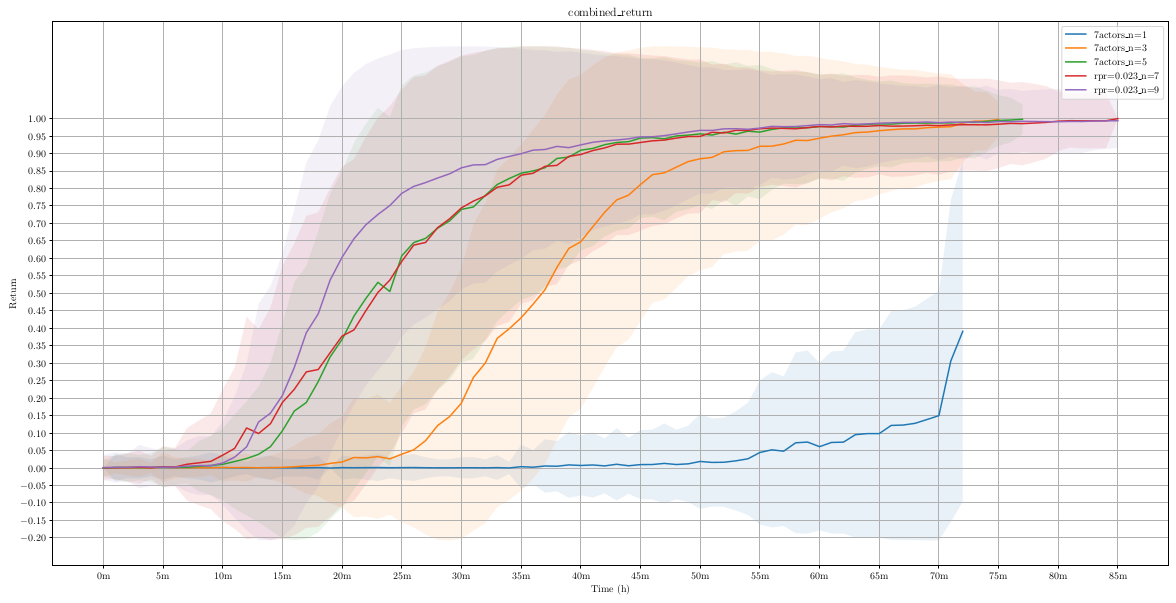

In [29]:
x_ticks = np.arange(0, 2000, step =5)
y_ticks = np.arange(-0.2, 1.05, step = 0.05)
y_ticks_per = np.arange(0, 101, step = 5)

fig = create_std_fig('combined_success_rate', 'Time (min)', '% Success Rate', x_ticks, y_ticks_per)
plt.xticks(x_ticks, ['{:.0f}'.format(x) + 'm' for x in x_ticks])
axes = plt.gca()
axes.set_ylim(bottom=0)
fig = create_std_fig('combined_return', 'Time (h)', 'Return', x_ticks, y_ticks, size_x =20, size_y = 10)
plt.xticks(x_ticks, ['{:.0f}'.format(x) + 'm' for x in x_ticks])

for exp in experiment_list:
    minutes = []
    mean_returns = []
    devs = []
    success_rates = []
    #print(actor)
    for minute, learning_step_values in combined_actor_time[exp].items():
        means, stds, num_samples, num_success = learning_step_values.values()
        mean, std = deviance(np.array(means), np.array(stds), np.array(num_samples))
        minutes.append(minute)
        mean_returns.append(mean)
        devs.append(std)
        success_rates.append(100*(np.sum(num_success)/np.sum(num_samples)))


    mean_returns = [mean for ls,mean in sorted(zip(minutes,mean_returns))]
    minutes.sort()
    #print(devs)
    plt.figure('combined_return')
    plt.plot(minutes, mean_returns, label = exp)
    plt.fill_between(minutes,y1= np.array(mean_returns)- np.array(devs), y2 =np.array(mean_returns)+np.array(devs),alpha=0.1)
    plt.figure('combined_success_rate')    
    plt.plot(minutes, success_rates, label = exp)
    
plt.legend()
plt.savefig('successrate_time.pgf')
plt.figure('combined_return')
plt.legend()
plt.savefig('return_time.pgf')
plt.show()

In [ ]:
import numpy as np; np.random.seed(5)
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

x = np.arange(10)
y = np.random.choice(10,10)

points = np.array([[0,5]).T.reshape(-1, 1, 2)
print(points.shape)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
print(segments.shape)

cm = dict(zip(range(-1,2,1),list("rbg")))
colors = list( map( cm.get , np.sign(np.diff(y))  ))

lc = LineCollection(segments, colors=colors, linewidths=2)
fig, ax = plt.subplots()
ax.add_collection(lc)

ax.autoscale()
ax.margins(0.1)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
a = np.random.randint(0, 1000, 10000)
print(a)
array = np.array([[0,0,1], [1,1,0], [0,0,0]])
print(array)

print(pd.unique(array[:]))

In [ ]:
seed = True

seeds = np.arange(7)
seeds += 7
print(list(seeds))

In [ ]:
seeds = list(np.arange(7)+2*7)
print(seeds)

In [23]:
my_dict=dict.fromkeys([1, 2, 3, 4])

In [24]:
my_dict[1]=2

In [25]:
my_dict

{1: 2, 2: None, 3: None, 4: None}

In [27]:
np.isfinite(np.inf)

False